# Dot Plot of Neuromodulator Receptor Expression in the Basolateral Amygdala

This notebook examines 10x single-cell RNA sequencing data from the Allen Brain Cell
(ABC) Atlas to visualize the expression of serotonin, norepinephrine, and dopamine
receptor genes across cell types in the **basolateral amygdala (BLA)** of the mouse brain.

The output is a **dot plot** showing mean expression (color) and fraction of expressing
cells (dot size) for each gene by BLA cell type (subclass level).

### Cell Type Selection
The BLA is part of the cortical subplate (CTXsp) dissection region. We include:
- **BLA excitatory neurons**: Subclasses with BLA/LA/BMA in their taxonomy names
  (region-specific, unambiguously from the BLA complex)
- **Major cortical interneuron classes**: Pvalb, Sst, Vip, Lamp5, Sncg and related
  subclasses from the CTXsp dissection

**Note on interneurons**: The 10x data lacks sub-regional spatial annotation within
CTXsp. GABAergic interneuron types (Sst, Pvalb, etc.) are shared across cortical
regions and cannot be localized to BLA vs. neighboring structures (CLA, EP, etc.)
from the 10x data alone. MERFISH spatial data confirms these types are present in
BLA but their transcriptomic clusters are not region-exclusive. The interneuron
expression profiles shown here therefore reflect a mixture of CTXsp interneurons,
of which a substantial fraction reside in BLA.

### Prerequisites
- Internet connection (for downloading data from AWS S3)
- Run the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) first
- Packages: `abc_atlas_access`, `anndata`, `scanpy`, `pandas`, `numpy`, `matplotlib`

In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

Set the download directory and create the cache object. Data will be downloaded
from AWS S3 on first access and cached locally for subsequent runs.

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)

print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata and Taxonomy

Load the cell metadata for all 4 million cells in the WMB-10X dataset,
the gene metadata, and the cluster taxonomy annotations.

In [3]:
# Load cell metadata
cell = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print(f"Total cells in WMB-10X: {len(cell):,}")

Total cells in WMB-10X: 4,042,976


In [4]:
# Load gene metadata
gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)
print(f"Total genes: {len(gene):,}")

Total genes: 32,285


In [5]:
# Load cluster taxonomy pivot table (maps cluster_alias -> all annotation levels)
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)

# Join taxonomy annotations onto cell metadata
cell_extended = cell.join(cluster_details, on='cluster_alias')
print(f"Taxonomy levels: {list(cluster_details.columns)}")
print(f"Cells with annotations: {len(cell_extended):,}")

Taxonomy levels: ['neurotransmitter', 'class', 'subclass', 'supertype', 'cluster']
Cells with annotations: 4,042,976


## 3. Identify BLA Cells

The basolateral amygdala (BLA) is part of the **cortical subplate (CTXsp)** dissection
region. CTXsp also contains claustrum (CLA), endopiriform nucleus (EP), medial amygdala
(MEA), cortical amygdala (COA), central amygdala (CEA), and striatal structures.

We select two categories of cells:
1. **BLA excitatory neurons** — subclasses with BLA/LA/BMA in their taxonomy names
2. **Major GABAergic interneuron classes** — Pvalb, Sst, Vip, Lamp5, Sncg and related
   subtypes from the CTXsp dissection (these are cortex-wide types confirmed present
   in BLA by MERFISH spatial data, but not exclusively BLA in the 10x data)

In [6]:
# Filter to CTXsp dissection region
ctxsp_cells = cell_extended[cell_extended['region_of_interest_acronym'] == 'CTXsp']
print(f"Cells in CTXsp region: {len(ctxsp_cells):,}")

# --- BLA excitatory neurons: subclasses with BLA/LA/BMA in name ---
bla_keywords = ['BLA', 'LA-BLA', 'BMA']
bla_excitatory = []
for sc_name in ctxsp_cells['subclass'].unique():
    for kw in bla_keywords:
        if kw in sc_name:
            bla_excitatory.append(sc_name)
            break

# --- Major cortical interneuron subclasses present in BLA ---
# These are cortex-wide GABAergic types confirmed in BLA by MERFISH spatial data.
# We include the canonical cortical interneuron classes and closely related subtypes.
interneuron_subclasses = [
    '052 Pvalb Gaba',
    '051 Pvalb chandelier Gaba',
    '053 Sst Gaba',
    '056 Sst Chodl Gaba',
    '046 Vip Gaba',
    '049 Lamp5 Gaba',
    '050 Lamp5 Lhx6 Gaba',
    '047 Sncg Gaba',
]

# Verify interneuron subclasses exist in CTXsp
ctxsp_subclasses = set(ctxsp_cells['subclass'].unique())
interneuron_subclasses = [s for s in interneuron_subclasses if s in ctxsp_subclasses]

# Combine both groups
bla_subclasses = sorted(set(bla_excitatory + interneuron_subclasses))

print(f"\nBLA excitatory subclasses ({len(bla_excitatory)}):")
for sc_name in sorted(bla_excitatory):
    count = (ctxsp_cells['subclass'] == sc_name).sum()
    print(f"  {sc_name}: {count:,} cells")

print(f"\nCTXsp interneuron subclasses ({len(interneuron_subclasses)}):")
for sc_name in sorted(interneuron_subclasses):
    count = (ctxsp_cells['subclass'] == sc_name).sum()
    print(f"  {sc_name}: {count:,} cells  (CTXsp-wide*)")

Cells in CTXsp region: 122,208

BLA excitatory subclasses (2):
  014 LA-BLA-BMA-PA Glut: 16,778 cells
  113 MEA-COA-BMA Ccdc42 Glut: 2,160 cells

CTXsp interneuron subclasses (8):
  046 Vip Gaba: 2,081 cells  (CTXsp-wide*)
  047 Sncg Gaba: 1,086 cells  (CTXsp-wide*)
  049 Lamp5 Gaba: 1,208 cells  (CTXsp-wide*)
  050 Lamp5 Lhx6 Gaba: 678 cells  (CTXsp-wide*)
  051 Pvalb chandelier Gaba: 418 cells  (CTXsp-wide*)
  052 Pvalb Gaba: 1,343 cells  (CTXsp-wide*)
  053 Sst Gaba: 2,609 cells  (CTXsp-wide*)
  056 Sst Chodl Gaba: 448 cells  (CTXsp-wide*)


In [7]:
# Filter to BLA excitatory + interneuron cells
bla_cells = ctxsp_cells[ctxsp_cells['subclass'].isin(bla_subclasses)].copy()

print(f"Total BLA cells selected: {len(bla_cells):,}")
print(f"  Excitatory (BLA-specific): {bla_cells['subclass'].isin(bla_excitatory).sum():,}")
print(f"  Inhibitory (CTXsp-wide): {bla_cells['subclass'].isin(interneuron_subclasses).sum():,}")

# Show subclass-level breakdown
print(f"\nAll selected subclasses ({len(bla_subclasses)}):")
for sc_name, count in bla_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    tag = "" if sc_name in bla_excitatory else " *"
    print(f"  {sc_name}: {count:,} cells{tag}")
print("\n* CTXsp-wide interneuron type (not BLA-exclusive)")

Total BLA cells selected: 28,809
  Excitatory (BLA-specific): 18,938
  Inhibitory (CTXsp-wide): 9,871

All selected subclasses (10):
  014 LA-BLA-BMA-PA Glut: 16,778 cells
  053 Sst Gaba: 2,609 cells *
  113 MEA-COA-BMA Ccdc42 Glut: 2,160 cells
  046 Vip Gaba: 2,081 cells *
  052 Pvalb Gaba: 1,343 cells *
  049 Lamp5 Gaba: 1,208 cells *
  047 Sncg Gaba: 1,086 cells *
  050 Lamp5 Lhx6 Gaba: 678 cells *
  056 Sst Chodl Gaba: 448 cells *
  051 Pvalb chandelier Gaba: 418 cells *

* CTXsp-wide interneuron type (not BLA-exclusive)


In [8]:
# Summarize by neurotransmitter and class
print("Cell type composition by neurotransmitter:")
for nt, count in bla_cells.groupby('neurotransmitter', observed=True).size().sort_values(ascending=False).items():
    print(f"  {nt}: {count:,}")

print(f"\nCell type composition by class:")
for cls_name, count in bla_cells.groupby('class', observed=True).size().sort_values(ascending=False).items():
    print(f"  {cls_name}: {count:,}")

Cell type composition by neurotransmitter:
  Glut: 18,938
  GABA: 9,792
  Glut-GABA: 79

Cell type composition by class:
  01 IT-ET Glut: 16,778
  07 CTX-MGE GABA: 5,048
  06 CTX-CGE GABA: 4,375
  13 CNU-HYa Glut: 2,160
  08 CNU-MGE GABA: 448


## 4. Define Receptor Gene Lists

We define three families of neuromodulator receptor genes (mouse nomenclature):
- **Serotonin (5-HT) receptors** (`Htr*`)
- **Norepinephrine (adrenergic) receptors** (`Adra*`, `Adrb*`)
- **Dopamine receptors** (`Drd*`)

In [9]:
# Serotonin (5-HT) receptors
serotonin_receptors = [
    'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f',
    'Htr2a', 'Htr2b', 'Htr2c',
    'Htr3a', 'Htr3b',
    'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'
]

# Norepinephrine (adrenergic) receptors
norepinephrine_receptors = [
    'Adra1a', 'Adra1b', 'Adra1d',
    'Adra2a', 'Adra2b', 'Adra2c',
    'Adrb1', 'Adrb2', 'Adrb3'
]

# Dopamine receptors
dopamine_receptors = [
    'Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5'
]

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
print(f"Total receptor genes: {len(all_receptors)}")
print(f"  Serotonin: {len(serotonin_receptors)}")
print(f"  Norepinephrine: {len(norepinephrine_receptors)}")
print(f"  Dopamine: {len(dopamine_receptors)}")

Total receptor genes: 28
  Serotonin: 14
  Norepinephrine: 9
  Dopamine: 5


In [10]:
# Verify which genes are present in the dataset
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
found_symbols = set(available_genes['gene_symbol'])
missing = [g for g in all_receptors if g not in found_symbols]

print(f"Found {len(found_symbols)}/{len(all_receptors)} receptor genes in the dataset")
if missing:
    print(f"Missing genes: {missing}")

# Update gene list to only include available genes
receptor_genes = [g for g in all_receptors if g in found_symbols]
print(f"\nUsing {len(receptor_genes)} genes for analysis")

Found 28/28 receptor genes in the dataset

Using 28 genes for analysis


## 5. Load Expression Data for BLA Cells

BLA cells come from the CTXsp expression matrices. We load the log2-normalized
data from both 10Xv2 and 10Xv3 chemistries and extract the receptor genes.

In [11]:
# Determine which expression matrix files contain our BLA cells
bla_matrices = bla_cells.groupby('feature_matrix_label').size()
print("Expression matrices containing BLA cells:")
for mat, count in bla_matrices.items():
    print(f"  {mat}: {count:,} cells")

Expression matrices containing BLA cells:
  WMB-10Xv2-CTXsp: 16,539 cells
  WMB-10Xv3-CTXsp: 12,270 cells


In [12]:
import os

gene_ensembl_ids = available_genes.index.tolist()
gene_symbols = available_genes['gene_symbol'].tolist()

neuronal_csv = 'bla_10x_neuronal_expression.csv'

if os.path.exists(neuronal_csv):
    expression_data = pd.read_csv(neuronal_csv, index_col=0)
    print(f"Loaded from {neuronal_csv}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
else:
    expression_frames = []
    for matrix_label in bla_matrices.index:
        dataset_label = bla_cells[bla_cells['feature_matrix_label'] == matrix_label]['dataset_label'].iloc[0]
        file_name = f"{matrix_label}/log2"
        
        print(f"\nLoading {file_name} from {dataset_label}...")
        file_path = abc_cache.get_file_path(directory=dataset_label, file_name=file_name)
        
        adata = anndata.read_h5ad(file_path, backed='r')
        
        gene_mask = adata.var.index.isin(gene_ensembl_ids)
        gene_filtered = adata.var[gene_mask]
        
        bla_cell_labels = bla_cells[bla_cells['feature_matrix_label'] == matrix_label].index
        cell_mask = adata.obs.index.isin(bla_cell_labels)
        
        print(f"  Cells in matrix: {len(adata.obs):,}")
        print(f"  BLA cells found: {cell_mask.sum():,}")
        print(f"  Receptor genes found: {gene_mask.sum()}")
        
        cell_idx = np.where(cell_mask)[0]
        gene_idx = np.where(gene_mask)[0]
        subset = adata[cell_idx, gene_idx].to_memory()
        
        expr_df = subset.to_df()
        expr_df.columns = gene_filtered['gene_symbol'].values
        
        expression_frames.append(expr_df)
        
        adata.file.close()
        del adata

    expression_data = pd.concat(expression_frames)
    expression_data.to_csv(neuronal_csv)
    print(f"\nSaved to {neuronal_csv}")

print(f"Total expression data: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")


Loading WMB-10Xv2-CTXsp/log2 from WMB-10Xv2...


  Cells in matrix: 44,310
  BLA cells found: 16,539
  Receptor genes found: 28



Loading WMB-10Xv3-CTXsp/log2 from WMB-10Xv3...


  Cells in matrix: 78,464
  BLA cells found: 12,270
  Receptor genes found: 28



Saved to bla_10x_neuronal_expression.csv
Total expression data: 28,809 cells x 28 genes


## 6. Build AnnData Object for Dot Plot

Combine the expression data with cell type annotations into a single
AnnData object for visualization with scanpy.

In [13]:
# Ensure expression columns are in the desired gene order
expression_data = expression_data[receptor_genes]

# Create AnnData object
adata_bla = anndata.AnnData(
    X=expression_data.values,
    obs=bla_cells.loc[expression_data.index, ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Create shorter display labels (strip leading number prefix)
import re
adata_bla.obs['subclass_short'] = adata_bla.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_bla.obs['supertype_short'] = adata_bla.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)

adata_bla.obs['subclass'] = pd.Categorical(adata_bla.obs['subclass'])
adata_bla.obs['supertype'] = pd.Categorical(adata_bla.obs['supertype'])
adata_bla.obs['subclass_short'] = pd.Categorical(adata_bla.obs['subclass_short'])
adata_bla.obs['supertype_short'] = pd.Categorical(adata_bla.obs['supertype_short'])

n_subclasses = adata_bla.obs['subclass'].cat.categories.size
n_supertypes = adata_bla.obs['supertype'].cat.categories.size
print(adata_bla)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes in BLA data")

AnnData object with n_obs × n_vars = 28809 × 28
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'subclass_short', 'supertype_short'

10 subclasses, 68 supertypes in BLA data


## 7. Dot Plot: Receptor Expression by BLA Cell Type (Subclass)

The dot plot shows:
- **Dot size**: Fraction of cells in each group expressing the gene (expression > 0)
- **Dot color**: Mean expression level (standard-scaled per gene)

Genes are grouped by receptor family (serotonin, norepinephrine, dopamine).
Cell types are grouped at the **subclass** level, combining BLA excitatory neurons
with major interneuron classes.

In [14]:
# Define gene groups for the dot plot
receptor_groups = {}

sero_available = [g for g in serotonin_receptors if g in receptor_genes]
ne_available = [g for g in norepinephrine_receptors if g in receptor_genes]
da_available = [g for g in dopamine_receptors if g in receptor_genes]

if sero_available:
    receptor_groups['Serotonin (5-HT)'] = sero_available
if ne_available:
    receptor_groups['Norepinephrine (NE)'] = ne_available
if da_available:
    receptor_groups['Dopamine (DA)'] = da_available

print("Gene groups for dot plot:")
for group, genes in receptor_groups.items():
    print(f"  {group}: {genes}")

Gene groups for dot plot:
  Serotonin (5-HT): ['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7']
  Norepinephrine (NE): ['Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3']
  Dopamine (DA): ['Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']


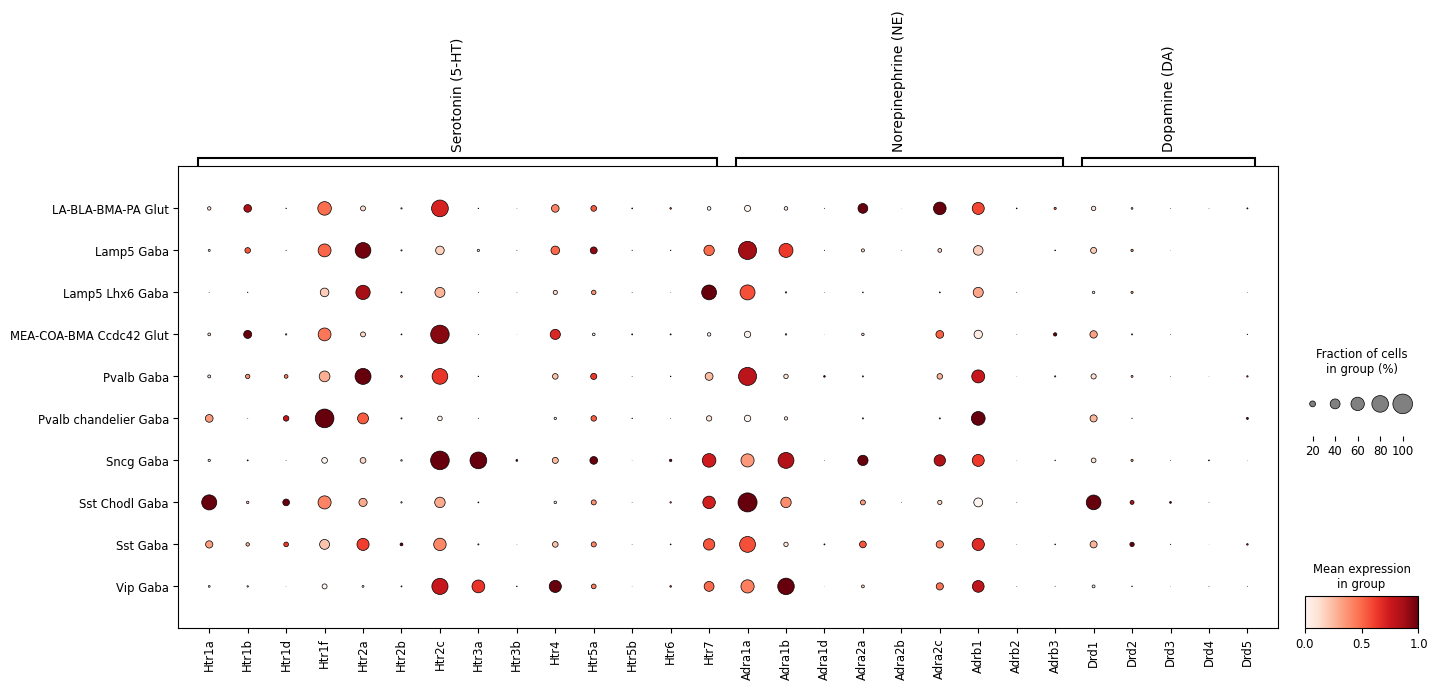

Saved: dotplot_BLA_receptors_by_subclass.png


In [15]:
# Create the dot plot grouped by subclass
dp = sc.pl.dotplot(
    adata_bla,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_BLA_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

For a finer-grained view, we plot at the supertype level (one level below subclass).
We filter to supertypes with at least 50 cells for readability.

Supertypes with >= 50 cells: 39


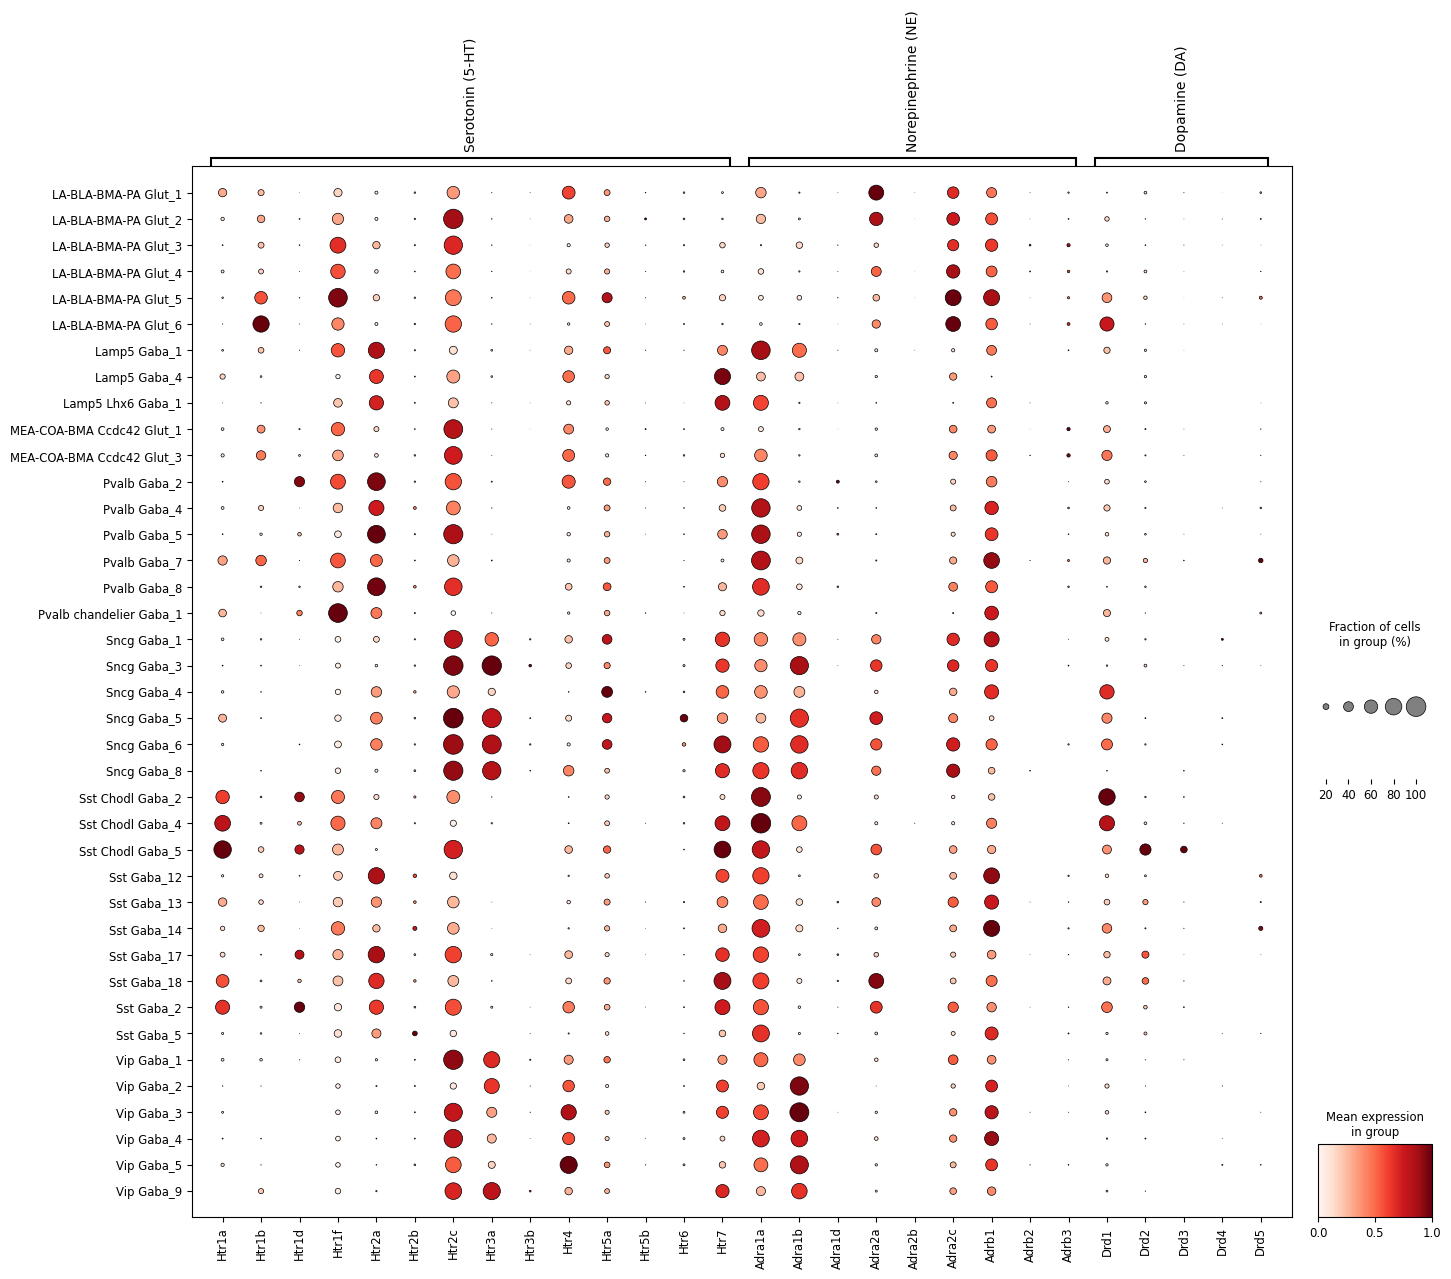

Saved: dotplot_BLA_receptors_by_supertype.png


In [16]:
# Filter to supertypes with sufficient cells
min_cells = 50
supertype_counts = adata_bla.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_supertype = adata_bla[adata_bla.obs['supertype'].isin(valid_supertypes)].copy()
adata_supertype.obs['supertype_short'] = pd.Categorical(adata_supertype.obs['supertype_short'])

n_supertypes = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_supertypes}")

dp2 = sc.pl.dotplot(
    adata_supertype,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(8, n_supertypes * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_BLA_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_receptors_by_supertype.png")

## 9. Including Glia: Neurons + Microglia + Astrocytes

A third dot plot adds **microglia** and **astrocytes** (Astro-TE) from the CTXsp
dissection alongside the neuronal subclasses, showing neuromodulator receptor
expression across all major cell classes in the BLA region.

CTXsp glia cells:
  319 Astro-TE NN: 19,140 cells
  334 Microglia NN: 6,164 cells


  WMB-10Xv2-CTXsp: 373 glia cells extracted


  WMB-10Xv3-CTXsp: 24,931 glia cells extracted


Saved to bla_10x_glia_expression.csv
Saved metadata to bla_10x_metadata.csv

Combined: 54,113 cells, 12 subclasses (neurons + glia)


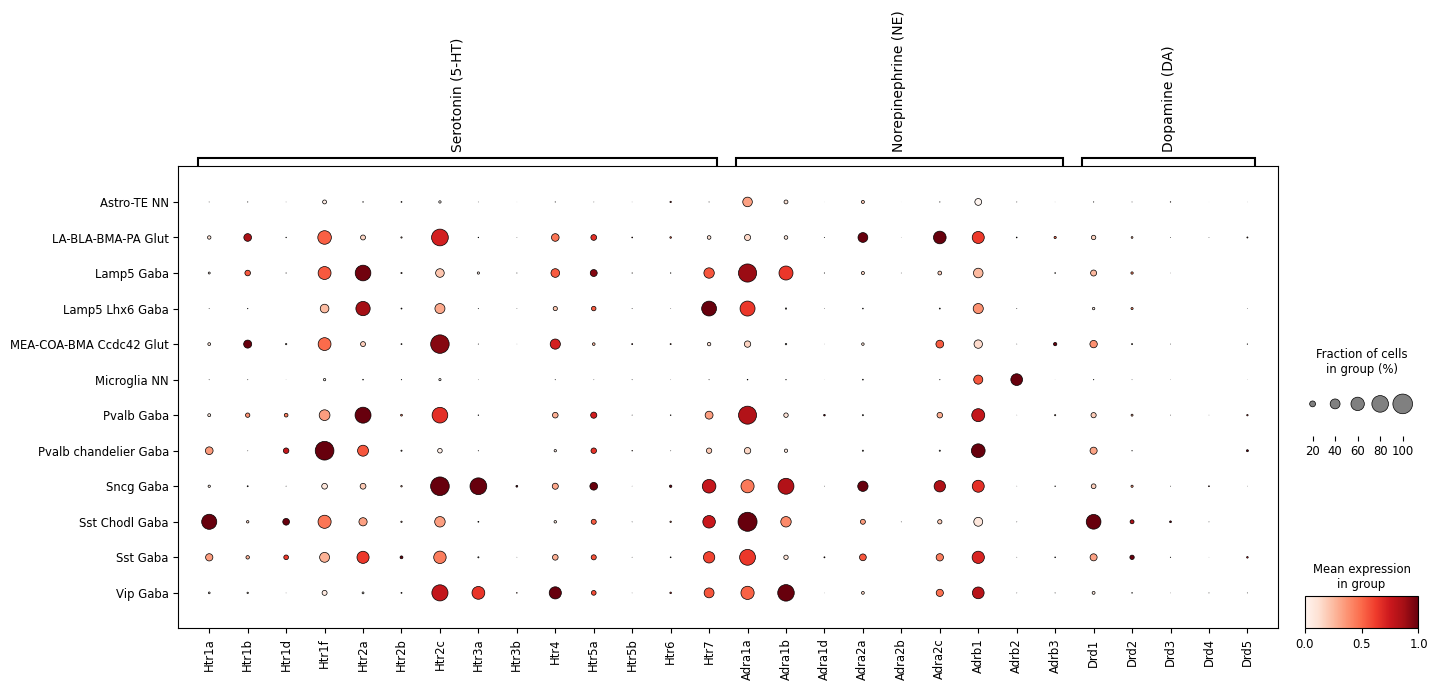

Saved: dotplot_BLA_receptors_with_glia.png


In [17]:
# Load glia cells from CTXsp
glia_subclasses = ['319 Astro-TE NN', '334 Microglia NN']
glia_cells = ctxsp_cells[ctxsp_cells['subclass'].isin(glia_subclasses)].copy()

print(f"CTXsp glia cells:")
for sc_name, count in glia_cells.groupby('subclass', observed=True).size().items():
    print(f"  {sc_name}: {count:,} cells")

# Extract glia expression (with CSV caching)
glia_csv = 'bla_10x_glia_expression.csv'

if os.path.exists(glia_csv):
    glia_expression = pd.read_csv(glia_csv, index_col=0)[receptor_genes]
    print(f"Loaded from {glia_csv}: {glia_expression.shape[0]:,} cells x {glia_expression.shape[1]} genes")
else:
    glia_matrices = glia_cells.groupby('feature_matrix_label').size()
    glia_expr_frames = []

    for matrix_label in glia_matrices.index:
        dataset_label = glia_cells[glia_cells['feature_matrix_label'] == matrix_label]['dataset_label'].iloc[0]
        file_name = f"{matrix_label}/log2"
        file_path = abc_cache.get_file_path(directory=dataset_label, file_name=file_name)
        
        adata = anndata.read_h5ad(file_path, backed='r')
        gene_mask = adata.var.index.isin(gene_ensembl_ids)
        gene_filtered = adata.var[gene_mask]
        glia_cell_labels = glia_cells[glia_cells['feature_matrix_label'] == matrix_label].index
        cell_mask = adata.obs.index.isin(glia_cell_labels)
        
        cell_idx = np.where(cell_mask)[0]
        gene_idx = np.where(gene_mask)[0]
        subset = adata[cell_idx, gene_idx].to_memory()
        expr_df = subset.to_df()
        expr_df.columns = gene_filtered['gene_symbol'].values
        glia_expr_frames.append(expr_df)
        
        adata.file.close()
        del adata
        print(f"  {matrix_label}: {cell_mask.sum():,} glia cells extracted")

    glia_expression = pd.concat(glia_expr_frames)[receptor_genes]
    glia_expression.to_csv(glia_csv)
    print(f"Saved to {glia_csv}")

# Combine neuronal + glia expression
combined_expression = pd.concat([expression_data, glia_expression])
combined_cells = pd.concat([bla_cells, glia_cells])

# Save combined metadata for downstream analysis
meta_csv = 'bla_10x_metadata.csv'
combined_cells.loc[combined_expression.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter']
].to_csv(meta_csv)
print(f"Saved metadata to {meta_csv}")

# Build combined AnnData
adata_combined = anndata.AnnData(
    X=combined_expression.values,
    obs=combined_cells.loc[combined_expression.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)
adata_combined.obs['subclass_short'] = adata_combined.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_combined.obs['subclass_short'] = pd.Categorical(adata_combined.obs['subclass_short'])

n_combined = adata_combined.obs['subclass_short'].cat.categories.size
print(f"\nCombined: {len(adata_combined):,} cells, {n_combined} subclasses (neurons + glia)")

# Generate dot plot
dp3 = sc.pl.dotplot(
    adata_combined,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_combined * 0.5)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_BLA_receptors_with_glia.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_BLA_receptors_with_glia.png")

## 10. Summary Statistics

Mean expression and fraction of expressing cells for each receptor gene by BLA subclass.

In [18]:
# Compute mean expression and fraction expressing per subclass
expr_df = pd.DataFrame(
    adata_bla.X,
    index=adata_bla.obs.index,
    columns=adata_bla.var.index
)
expr_df['subclass'] = adata_bla.obs['subclass'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 80)
print("Mean Expression (log2) by Subclass")
print("=" * 80)
display(mean_expr.round(2))

print("\n" + "=" * 80)
print("Fraction of Expressing Cells by Subclass")
print("=" * 80)
display(frac_expr.round(3))

Mean Expression (log2) by Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
014 LA-BLA-BMA-PA Glut,0.53,1.61,0.05,4.23,0.91,0.13,6.45,0.05,0.01,1.78,...,0.00,3.21,2.95,0.08,0.28,0.76,0.22,0.01,0.01,0.10
046 Vip Gaba,0.24,0.18,0.00,0.96,0.27,0.11,6.87,4.17,0.07,3.80,...,0.00,1.56,3.33,0.01,0.02,0.46,0.07,0.00,0.01,0.02
047 Sncg Gaba,0.29,0.10,0.01,1.02,1.07,0.15,8.74,6.44,0.20,1.20,...,0.00,2.71,3.02,0.01,0.05,0.81,0.30,0.01,0.08,0.00
049 Lamp5 Gaba,0.26,1.03,0.02,4.37,5.07,0.13,2.20,0.33,0.02,2.07,...,0.01,0.64,2.19,0.00,0.07,1.13,0.33,0.00,0.00,0.00
050 Lamp5 Lhx6 Gaba,0.02,0.04,0.00,2.22,4.52,0.10,2.94,0.03,0.01,0.84,...,0.00,0.11,2.43,0.02,0.00,0.35,0.30,0.00,0.00,0.01
051 Pvalb chandelier Gaba,1.59,0.01,1.00,7.66,2.89,0.12,0.78,0.02,0.00,0.32,...,0.00,0.12,3.71,0.00,0.00,1.39,0.04,0.00,0.00,0.25
052 Pvalb Gaba,0.41,0.71,0.57,2.89,5.17,0.20,5.95,0.05,0.00,1.12,...,0.00,0.97,3.26,0.00,0.12,0.85,0.25,0.01,0.00,0.15
053 Sst Gaba,1.54,0.53,0.81,2.44,3.31,0.40,4.05,0.13,0.01,1.11,...,0.00,1.43,3.11,0.01,0.07,1.41,0.75,0.03,0.00,0.18
056 Sst Chodl Gaba,4.50,0.32,1.29,3.76,1.78,0.14,3.20,0.09,0.00,0.39,...,0.01,0.66,1.83,0.01,0.00,4.25,0.62,0.22,0.01,0.00



Fraction of Expressing Cells by Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
014 LA-BLA-BMA-PA Glut,0.097,0.286,0.010,0.611,0.158,0.027,0.808,0.009,0.001,0.283,...,0.000,0.556,0.521,0.015,0.056,0.137,0.041,0.003,0.002,0.022
046 Vip Gaba,0.041,0.030,0.001,0.161,0.044,0.020,0.769,0.565,0.012,0.527,...,0.000,0.262,0.504,0.002,0.003,0.078,0.012,0.001,0.003,0.003
047 Sncg Gaba,0.058,0.019,0.003,0.193,0.197,0.032,0.932,0.810,0.042,0.209,...,0.000,0.483,0.517,0.001,0.010,0.151,0.054,0.003,0.017,0.001
049 Lamp5 Gaba,0.047,0.187,0.005,0.572,0.740,0.025,0.333,0.056,0.003,0.335,...,0.002,0.113,0.384,0.000,0.014,0.206,0.059,0.001,0.000,0.000
050 Lamp5 Lhx6 Gaba,0.003,0.007,0.000,0.335,0.655,0.019,0.407,0.004,0.001,0.128,...,0.000,0.019,0.412,0.003,0.000,0.062,0.053,0.000,0.000,0.001
051 Pvalb chandelier Gaba,0.287,0.002,0.184,0.938,0.459,0.024,0.144,0.005,0.000,0.060,...,0.000,0.024,0.622,0.000,0.000,0.258,0.007,0.000,0.000,0.048
052 Pvalb Gaba,0.080,0.134,0.109,0.448,0.759,0.042,0.741,0.010,0.000,0.189,...,0.000,0.185,0.576,0.001,0.025,0.171,0.048,0.002,0.001,0.031
053 Sst Gaba,0.266,0.099,0.148,0.401,0.526,0.077,0.544,0.023,0.001,0.190,...,0.000,0.268,0.533,0.002,0.014,0.255,0.135,0.006,0.000,0.035
056 Sst Chodl Gaba,0.703,0.062,0.239,0.583,0.312,0.029,0.433,0.018,0.000,0.065,...,0.002,0.132,0.348,0.002,0.000,0.681,0.118,0.042,0.002,0.000
